# Build Expalinabl Classifier using SHAP

#### Load the data and observe its' fields.

In [1]:
import pandas as pd
import os

vehicle_data = pd.read_csv(os.path.abspath("kaggle_data.csv"))
vehicle_data.head()



,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,E.V_Type,CAFV,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,JTMAB3FV3P,Kitsap,Seabeck,WA,98380.0,2023,TOYOTA,RAV4 PRIME,PHEV,known,42.0,0.0,35.0,240684006,POINT (-122.8728334 47.5798304),PUGET SOUND ENERGY INC,5.303509e+10
1,1N4AZ1CP6J,Kitsap,Bremerton,WA,98312.0,2018,NISSAN,LEAF,BEV,known,151.0,0.0,35.0,474183811,POINT (-122.6961203 47.5759584),PUGET SOUND ENERGY INC,5.303508e+10
2,5YJ3E1EA4L,King,Seattle,WA,98101.0,2020,TESLA,MODEL 3,BEV,known,266.0,0.0,43.0,113120017,POINT (-122.3340795 47.6099315),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
3,1N4AZ0CP8E,King,Seattle,WA,98125.0,2014,NISSAN,LEAF,BEV,known,84.0,0.0,46.0,108188713,POINT (-122.304356 47.715668),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303300e+10
4,1G1FX6S00H,Thurston,Yelm,WA,98597.0,2017,CHEVROLET,BOLT EV,BEV,known,238.0,0.0,20.0,176448940,POINT (-122.5715761 46.9095798),PUGET SOUND ENERGY INC,5.306701e+10


In [2]:
print(vehicle_data['E.V_Type'].unique())

['PHEV' 'BEV']


## Model Training

### Load useful libraries

#### Make sure you have installed the libraries to your computing environment

In [3]:
import shap  
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn import datasets
import matplotlib.pyplot as plt


A Random Forest classifier is built to predict diabetes outcomes using the diabetes dataset. .

In [32]:
# Separate Features and Target Variables
X = vehicle_data.drop(columns=['VIN (1-10)','County', 'City', 'State', 'Postal Code', 'E.V_Type', 'Legislative District', 'DOL Vehicle ID', 'Vehicle Location', 'Electric Utility', '2020 Census Tract'])

X = pd.get_dummies(X, columns=['Make', 'Model', 'CAFV'])

y = vehicle_data['E.V_Type']

# Create Train & Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.003,stratify =y,random_state = 13)

# Build the model
rf_clf = RandomForestClassifier(max_features=2, n_estimators =100 ,bootstrap = True)

rf_clf.fit(X_train, y_train)

# Make prediction on the testing data 
y_pred = rf_clf.predict(X_test)

# Classification Report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         BEV       1.00      1.00      1.00       485
        PHEV       1.00      1.00      1.00       132

    accuracy                           1.00       617
   macro avg       1.00      1.00      1.00       617
weighted avg       1.00      1.00      1.00       617



The above statistics shows the random forest classifier provides a decent performance in predicting diabetes outcomes, with obvious room for improvement using different models.

### We can integrate the explainability layer into this model to provide more insights into its predictions using SHAP ( SHapley Additive exPlanations). 

#### SHAP aims to explain the prediction of an instance/observation by computing the contribution of each feature to the prediction.

The TreeExplainer class is used to explain tree-based models, along with the initjs.
shape.initjs() function initializes the JavaScript code required to display SHAP visualizations in a jupyter notebook environment.
Finally, after instantiating the TreeExplainer class with the random forest classifier, the shape values are computed for each feature of each instance in the test dataset.


In [33]:
shap.initjs()
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_test, check_additivity=False)

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. Consider retrying with the feature_perturbation='interventional' option. This check failed because for one of the samples the sum of the SHAP values was 1478.400868, while the model output was 1.000000. If this difference is acceptable you can set check_additivity=False to disable this check.

SHAP offers an array of visualization tools for enhancing model interpretability, and the next section will discuss two of them: (1) variable importance with the summary plot, (2) summary plot of a specific target, and (3) dependence plot.



### Variable Importance with Summary Plot


In this plot, features are ranked by their average SHAP values showing the most important features at the top and the least important ones at the bottom using the summary_plot() function. This helps to understand the impact of each feature on the model’s predictions.

Variable Importance Plot - Global Interpretation


<Figure size 640x480 with 0 Axes>

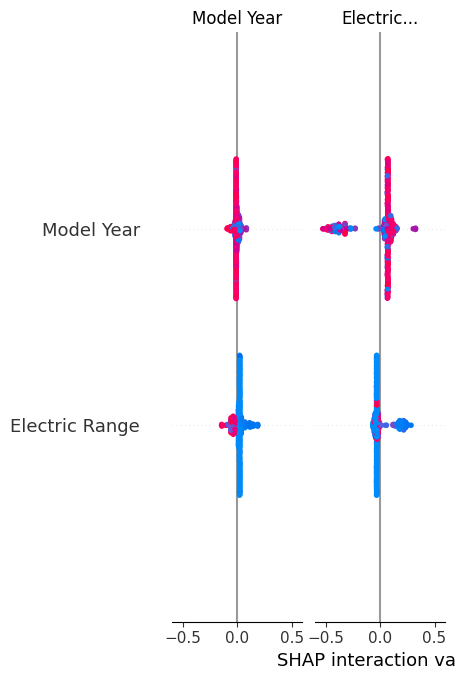

In [31]:
print("Variable Importance Plot - Global Interpretation")
figure = plt.figure()
shap.summary_plot(shap_values, X_test)

In the above figure, we can observe that the red and blue colors occupy half of the horizontal rectangles for each class. This means that each feature has an equal impact on the classification of both diabetes (label=1) and non-diabetes (label=0) cases.
However, Glucose, Age, and BMI are the first three features with the most predictive power.
On the other hand, Pregnancies, SkinThicknes, Insulin, and BloodPressure do not contribute as much as the first three features.

### Summary Plot on a Specific Label


This approach can provide a more granular overview of the impact of each feature on a specific outcome (label).
In the example below, shap_values[1] is used to represent the SHAP values for instances classified as label 1 (having diabetes).

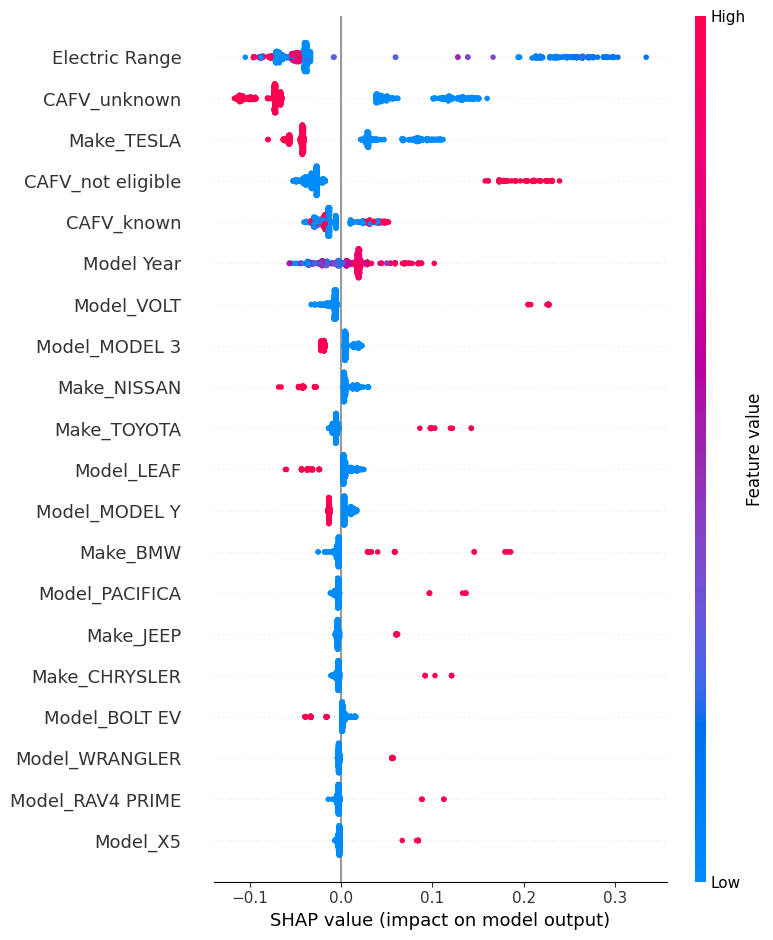

In [17]:
shap.summary_plot(shap_values[:,:,1], X_test)

#:,:,

From the above graphic, follwing explainbility can be inferred:

<li>Y-axis represents the features ranked by their average absolute SHAP values, similar to the graphic in image.</li>
<li>X-axis represents SHAP values. Positive values for a given feature push the model’s prediction closer to the label being examined (label=1). In contrast, negative values push towards the opposite class (label=0)..</li>
<li>An individual with a high glucose (red dots) level is likely to be diagnosed with diabetes (positive outcome), while a low glucose level leads to not being diagnosed with diabetes.</li>
<li>Similarly, aging patients are more likely to be diagnosed with diabetes. However, the model seems uncertain about the diagnosis for younger patients.    </li>


#### One way of dealing with this ambiguity for the Age attribute is using the dependence plot to gain more insights.

### Dependence Plot

Unlike summary plots, dependence plots show the relationship between a specific feature and the predicted outcome for each instance within the data. This analysis is performed for multiple reasons and is not limited to gaining more granular information and validating the importance of the feature being analyzed by confirming or challenging the findings from the summary plots or other global feature importance measures. 

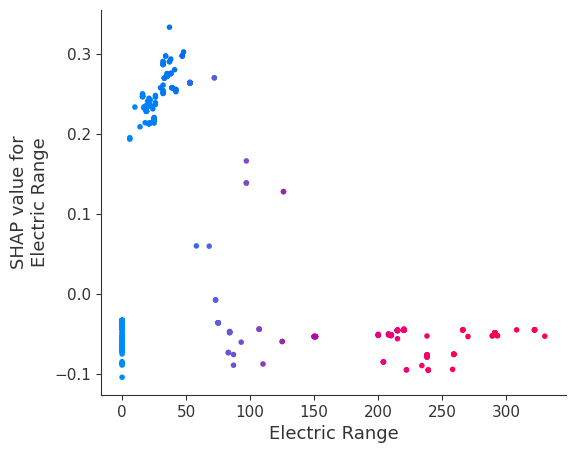

In [21]:
# Dependence Plot on Age feature
shap.dependence_plot('Electric Range', shap_values[:,:,1], X_test, interaction_index="Electric Range")

The dependence plot reveals that patients under 30 have a lower risk of being diagnosed with diabetes. In contrast, individuals over 30 face a higher likelihood of receiving a diabetes diagnosis.

In [23]:
from lime.lime_tabular import LimeTabularExplainer

# Get the class names
class_names = ['Has diabetes', 'No diabetes']

# Get the feature names
feature_names = list(X_train.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.values, feature_names =     
                                 feature_names,
                                 class_names = class_names, 
                                 mode = 'classification')

/home/alberto_zuin/OneDrive/Hull University/Ethical, Regulatory and Social Aspects for fair AI/Ethics/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [22]:
#Perform the explanation on the 8th instance in the test data
explaination = explainer.explain_instance(X_test.iloc[8], rf_clf.predict_proba)

# show the result of the model's explaination
explaination.show_in_notebook(show_table = True, show_all = False)

AttributeError: 'TreeExplainer' object has no attribute 'explain_instance'

The  above result contains three main pieces of information from left to right: (1) the model’s predictions, (2) features contributions, and (3) the actual value for each feature.

We can observe that the eight patient is predicted to have diabetes with 72% confidence. The reasons that led the model to make this decision is because:

The patient’s glucose level is more than 99.
The blood pressure is more than 70.
Those values can be verified from the table on the right.

### Limitation

These methods can only be applied to a limited category of models. Some of those models include linear regression, decision trees, and neural network interpretability. More deatils on it, you can find here. 
[Here](https://www.datacamp.com/tutorial/explainable-ai-understanding-and-trusting-machine-learning-models)